# Titanic - Desafio de Aprendizado de Máquina

<p align="center">
  <img src="https://sigmoidal.ai/wp-content/uploads/2022/06/titanic.jpg" alt="Titanic">
</p>

A tragédia do Titanic, ocorrida em abril de 1912, permanece como um dos eventos mais icônicos e trágicos da história da humanidade. Esse desastre marítimo não apenas tirou a vida de mais de 1.500 pessoas, mas também destacou questões cruciais relacionadas à engenharia naval, política de segurança marítima e desigualdade social. Neste notebook de análise, examinaremos profundamente os diversos aspectos que envolvem o naufrágio do Titanic, desde as circunstâncias que levaram ao acidente até o legado duradouro que deixou no mundo. Utilizando dados históricos, testemunhos de sobreviventes e insights de especialistas, nossa análise visa lançar luz sobre as lições aprendidas a partir deste trágico evento e como ele continua a moldar a sociedade e as indústrias até os dias atuais.

**Dicionário**

| Variável | Definição                                | Chave                                          |
| -------- | ---------------------------------------- | ---------------------------------------------- |
| survival | Sobrevivel                               | 0 = Não, 1 = Sim                               |
| pclass   | Classe do bilhete                        | 1 = 1º Classe, 2 = 2º Classe, 3 = 3º Classe    |
| name     | Nome do passageiro                       |                                                |
| sex      | Sexo                                     |                                                |
| Age      | Idade em anos                            |                                                |
| sibsp    | Nº de irmãos/cônjuges a bordo            |                                                |
| parch    | Nº de pais/filhos a bordo                |                                                |
| ticket   | Número do bilhete                        |                                                |
| fare     | Valor da passagem                        |                                                |
| cabin    | Número de cabine                         |                                                |
| embarked | Porto de embarque                        | C = Cherbourg, Q = Queenstown, S = Southampton |

In [236]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
warnings.simplefilter("ignore")

In [237]:
# Visualizando a base de treino
treino = pd.read_csv('train.csv')
rows, cols = treino.shape
print(f'Total de linhas: {rows}\nTotal de colunas: {cols}')
treino.head(3)

Total de linhas: 891
Total de colunas: 12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- **Base de treino**

In [238]:
# Verificando as informações da base
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [239]:
# analisando dados estatísticos
treino.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Temos uma média de idade em torno de 29 anos, sendo o máximo com 80 anos. Para a época de 1912, a expectativa de vida era entre 50 a 60 anos. É assustador quando comparamos com a idade que nossos avós alcançam hoje em dia. Se olharmos para a expectativa de vida no Brasil naquela época, era de apenas 33,7 anos. Realmente impressionante! 

O atributo Fare (passagem) está estranho, com uma média de 32,20 e uma mediana de 14,45. Os valores estão um pouco distorcidos.

In [240]:
# Verificando porcentagem de valores ausentes
round(treino.isnull().mean()*100,2)

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

- **Base de teste**

In [241]:
teste = pd.read_csv('test.csv')

In [242]:
# Verificando as informações da base
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [243]:
# analisando dados estatísticos
teste.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


In [244]:
# Verificando porcentagem de valores ausentes
round(teste.isnull().mean()*100,2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.57
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.24
Cabin          78.23
Embarked        0.00
dtype: float64

## Visualização dos dados

In [245]:
aggregated_data = treino[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
aggregated_data

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


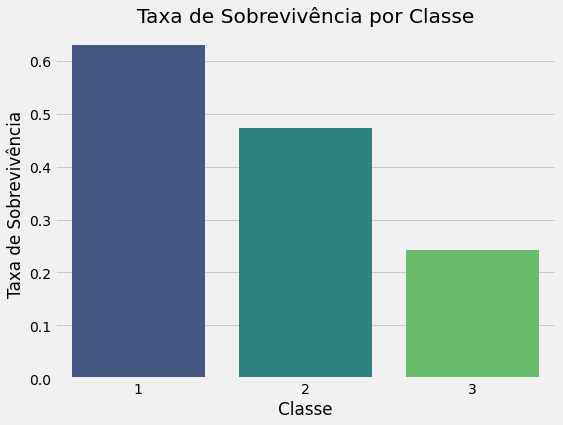

In [246]:
plt.figure(figsize=(8, 6))
sns.barplot(data=aggregated_data, x='Pclass', y='Survived', palette='viridis')
plt.xlabel('Classe')
plt.ylabel('Taxa de Sobrevivência')
plt.title('Taxa de Sobrevivência por Classe')
plt.show()

In [247]:
aggregated_data = treino[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
aggregated_data

,Sex,Survived
0,female,0.742038
1,male,0.188908


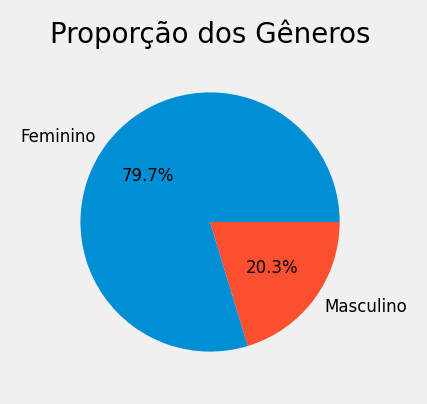

In [248]:

plt.figure(figsize=(2, 2), dpi=200) 
mylabels = ["Feminino", "Masculino"]
plt.pie(aggregated_data['Survived'], labels=mylabels, autopct='%1.1f%%', textprops={'fontsize': 6})
plt.title('Proporção dos Gêneros', fontsize=10)
plt.show()


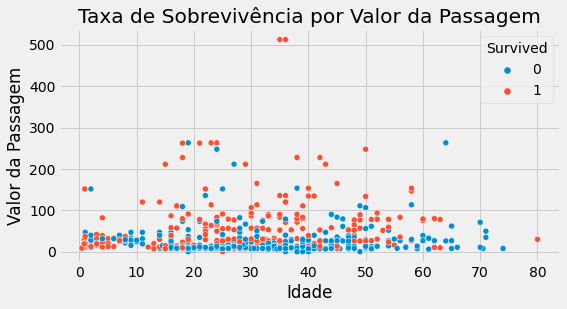

In [249]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=treino, x='Age', y='Fare', hue='Survived')
plt.xlabel('Idade')
plt.ylabel('Valor da Passagem')
plt.title('Taxa de Sobrevivência por Valor da Passagem')
plt.show()

Como já observado anteriormente, o valor da passagem está relacionado com a sobrevivência, havendo uma tendência de maior probabilidade de sobrevivência caso haja um pagamento mais elevado.

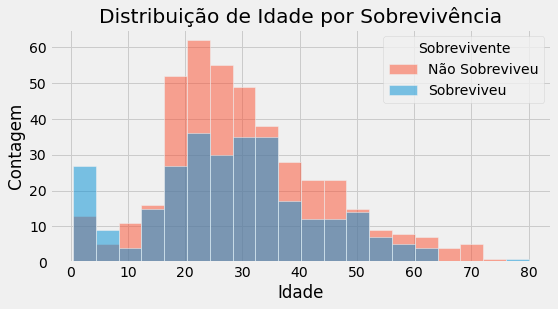

In [250]:
plt.figure(figsize=(8, 4))
sns.histplot(data=treino, x='Age', hue='Survived', hue_order=[1,0])
plt.legend(title='Sobrevivente', labels=['Não Sobreviveu', 'Sobreviveu'])
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.title('Distribuição de Idade por Sobrevivência')
plt.show()

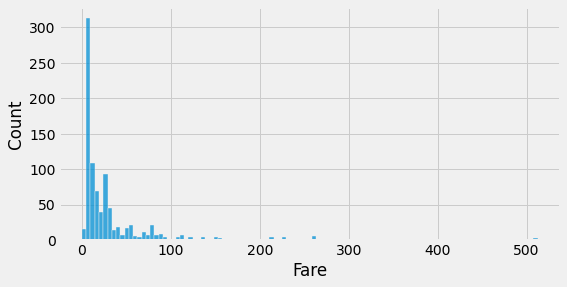

In [251]:
plt.figure(figsize=(8, 4))
sns.histplot(data=treino, x='Fare')
plt.show()

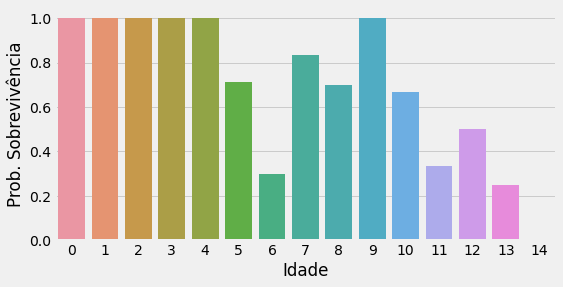

In [252]:
plt.figure(figsize=(8, 4))
aggregated_data = treino[treino.Age <=10].groupby(['Age'], as_index=False).mean()
sns.barplot(data=aggregated_data, x=aggregated_data.index, y='Survived')
plt.xlabel('Idade')
plt.ylabel('Prob. Sobrevivência')
plt.show()

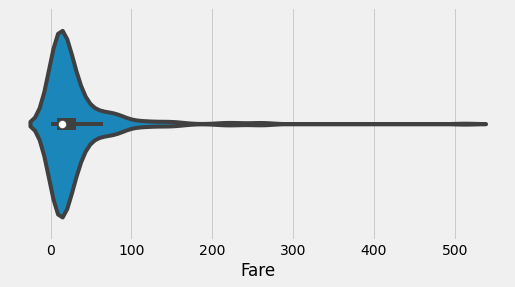

In [253]:
plt.figure(figsize=(8, 4))
sns.violinplot(data=treino, x='Fare')
plt.show()

(0.0, 100.0)

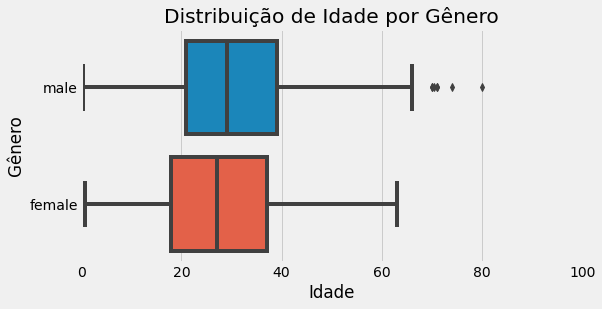

In [254]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=treino, x='Age', y='Sex', orient='h')
plt.xlabel('Idade')
plt.ylabel('Gênero')
plt.title('Distribuição de Idade por Gênero')
plt.xlim(0, 100)

Podemos observar o seguinte padrão de sobrevivência com base na análise dos dados:
- Bebês (idade <= 4) apresentaram uma alta taxa de sobrevivência.
- Houve um número significativo de jovens entre 15 e 30 anos que não sobreviveram.
- A faixa etária mais comum entre os passageiros situa-se entre 18 e 39 anos.

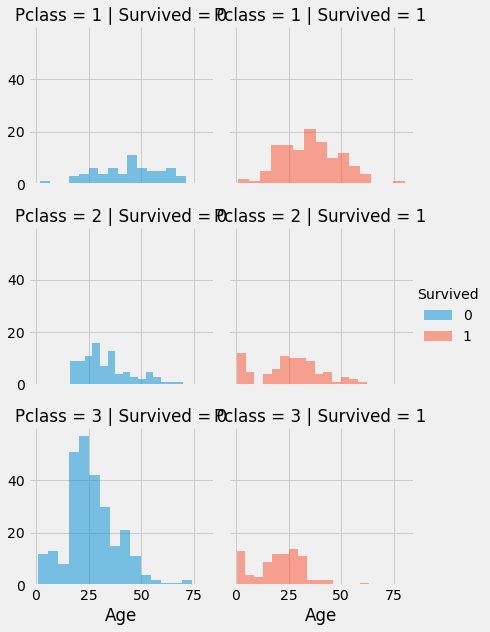

In [255]:
grid = sns.FacetGrid(treino, col='Survived', row='Pclass', hue='Survived')
grid.map(plt.hist, 'Age', alpha=.5, bins=15)
grid.add_legend()
plt.show()

# Analise mais detalhada

Estamos empenhados em tornar nossos dados mais realistas. Durante a tragédia, mulheres e crianças foram consideradas prioridades, e sabemos que cada mulher casada, possui um título. Portanto, podemos extrair essas informações da coluna `nome`, que até então não havíamos levado em consideração.

- `mr` -> Senhor (usado para homens casados)
- `mrs` -> Senhora  (usado para mulheres casadas)
- `miss` -> Srta. / Senhorita
- `master` -> Senhor (usado para um jovem)
- `don` -> Dom
- `rev` -> Reverendo
- `dr` -> Doutor
- `mme` -> Madame (equivalente a Senhora em francês)
- `ms` -> Senhorita / Senhora (usado como forma neutra de tratamento)
- `major` -> Major (grau militar)
- `lady` -> Dama / Senhora
- `sir` -> Senhor / Cavaleiro
- `mlle` -> Mademoiselle (equivalente a Senhorita em francês)
- `col` -> Coronel (grau militar)
- `capt` -> Capitão (grau militar)
- `the countess` -> Condessa
- `jonkheer` -> Título nobiliárquico da Baixa Saxônia, Holanda e Bélgica (equivalente a nobre).

In [256]:
treino_filtrado = treino.copy()
teste_filtrado = teste.copy()

In [257]:
# Função para extrair o titulo de cada nome
def extrair_titulo(df):
    df['Titulo'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip().lower())

Além disso, podemos agrupar alguns títulos, como 'mlle', que é equivalente a 'miss', assim como 'ms'. Quanto aos outros títulos de patente, como 'doutor' e 'coronel', podemos tratá-los como casos raros.

In [258]:
data = [treino_filtrado, teste_filtrado]

# Crie uma instância do LabelEncoder
label_encoder = LabelEncoder()
titulo = {"mr": 1, "miss": 2, "mrs": 3, "master": 4, "raro": 5}

for dataset in data:
    # Extraindo os titulos dos nomes
    extrair_titulo(dataset)
    
    # Substituindo os títulos por um título mais comum ou como Raro
    dataset['Titulo'] = dataset['Titulo'].replace('mlle', 'miss')
    dataset['Titulo'] = dataset['Titulo'].replace('ms', 'miss')
    dataset['Titulo'] = dataset['Titulo'].replace('mme', 'mrs')
    dataset['Titulo'] = dataset['Titulo'].replace(['lady', 'the countess', 'countess','capt', 'col','don', 'dr', 'major', 'rev', 'sir', 'jonkheer', 'dona'], 'raro')
    
    # Usar o LabelEncoder para converter títulos em números
#     dataset['Titulo'] = label_encoder.fit_transform(dataset['Titulo'])
    dataset['Titulo'] = dataset['Titulo'].map(titulo)
    
    dataset.drop(['Name'], axis=1, inplace=True)

In [259]:
# treino_filtrado = pd.get_dummies(treino_filtrado, columns=['Titulo'])
# teste_filtrado = pd.get_dummies(teste_filtrado, columns=['Titulo'])  

# data = [treino_filtrado, teste_filtrado]

## Dados Ausentes

### Pré-processamento dos dados

#### Idade

Vamos continuar com a média das idades para preencher os dados ausentes.

In [260]:
for dataset in data:
    dataset.loc[dataset.Age.isnull(), 'Age'] = dataset.Age.mean()
    dataset['Age'] = dataset.Age.astype(int)

In [261]:
for cat, inter in enumerate(pd.qcut(treino_filtrado.Age, 5).cat.categories):
    print(f'Categoria: {cat}\t|\tIntervalo: {inter}')

Categoria: 0	|	Intervalo: (-0.001, 20.0]
Categoria: 1	|	Intervalo: (20.0, 28.0]
Categoria: 2	|	Intervalo: (28.0, 29.0]
Categoria: 3	|	Intervalo: (29.0, 38.0]
Categoria: 4	|	Intervalo: (38.0, 80.0]


In [262]:
for dataset in data:
    dataset['Age'] = pd.qcut(dataset.Age, 5, labels=False)

#### Classe

#### Fare e Embarked

Para o atributo `Fare`, só temos uma única instância ausente

In [263]:
teste_filtrado[teste_filtrado['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titulo
152,1044,3,male,4,0,0,3701,NaN,NaN,S,1


Para encontrar informações semelhantes, podemos realizar uma consulta (query) considerando diversas características relevantes, tais como a classe da pessoa, o local de embarque e se ela estava acompanhada. Através desse processo, obtemos a média das pessoas com características semelhantes, o que nos permite preencher o dado faltante de forma mais precisa e confiável.

In [264]:
filtro = "Pclass == 3 and Embarked == 'S' and SibSp == 0 and Parch == 0 and Sex == 'male'"
teste_filtrado.query(filtro)['Fare'].mean()

9.096774666666665

In [265]:
# Preenchendo o valor da passagem com semelhança de passageiros
teste_filtrado.loc[teste_filtrado.Fare.isnull(), 'Fare'] = teste_filtrado.query(filtro)['Fare'].mean()

In [266]:
for cat, inter in enumerate(pd.qcut(teste_filtrado.Fare, 5).cat.categories):
    print(f'Categoria: {cat}\t|\tIntervalo: {inter}')

Categoria: 0	|	Intervalo: (-0.001, 7.796]
Categoria: 1	|	Intervalo: (7.796, 10.667]
Categoria: 2	|	Intervalo: (10.667, 21.196]
Categoria: 3	|	Intervalo: (21.196, 46.34]
Categoria: 4	|	Intervalo: (46.34, 512.329]


In [267]:
for dataset in data:
    dataset['Fare'] = pd.qcut(dataset.Fare, 5, labels=False)

No caso do atributo `Embarked`, em que dispomos de informações limitadas para determinar o local de embarque do passageiro, a melhor abordagem é preencher os dados faltantes com a moda.

In [268]:
# Preenchendo Embarque com a moda
treino_filtrado.loc[treino_filtrado.Embarked.isnull(), 'Embarked'] = treino_filtrado.Embarked.mode()[0]

Alem disso, temos aluns valores estranho, pessoas viajando pagando 0 dinheiros

In [269]:
# # Calcular a média dos valores não-zero agrupados por Pclass e Sex
# fare_mean_by_class_sex = treino_filtrado[treino_filtrado.Fare > 0].groupby(['Pclass', 'Sex','Embarked'])['Fare'].mean()

# # Função para substituir os valores zero pelo valor médio correspondente
# def replace_zero_fare(row):
#     if row['Fare'] == 0:
#         return fare_mean_by_class_sex[row['Pclass'], row['Sex'], row['Embarked']]
#     return row['Fare']

# # Aplicar a função para substituir os valores zero na coluna Fare
# treino_filtrado['Fare'] = treino_filtrado.apply(replace_zero_fare, axis=1)
# teste_filtrado['Fare'] = teste_filtrado.apply(replace_zero_fare, axis=1)

In [270]:
# for dataset in data:
#     dataset['Age_Class']= dataset['Age']* dataset['Pclass']

#### Cabines

As Cabinas possuem aproximadamente 77% de seus dados ausentes, então poderíamos cogitar em eliminar essa coluna, porém, pesquisando sobre as cabines do RSM Titanic, encontrei a seguinte imagem:

<p align="center">
    <img src="image/setor_cabines.png" alt="Protótipo de imagem das cabinas frontal do RSM Titanic" width="300">
    <img src="image/ward_map_class.png" alt="Protótipo de imagem das cabinas leterais do RSM Titanic" width="400">
</p>

A maior parte das instalações e acomodações da Primeira Classe no Titanic situava-se nos conveses superiores, proporcionando aos passageiros um ambiente com menores vibrações e ruídos dos motores. O Convés `A`, assim como a maioria dos conveses `B` e `C`, era dedicado ao espaço de recreação e alojamento da Primeira Classe. Além disso, as acomodações da Primeira Classe estendiam-se por todos os níveis até o Convés `F`, garantindo aos passageiros desta classe um espaço superior em relação às outras classes a bordo.

<p align="center">
    <img src="image/titanic_class.jpg" width="1000">
</p>

A partir das localizações conhecidas, podemos tentar analisar o trágico acidente que ocorreu à noite, quando grande parte dos passageiros estava em seus aposentos. Inicialmente, vamos buscar obter informações disponíveis, considerando que temos muitos dados ausentes. Podemos usar essa informação parcial como um adicional para a nossa análise. Se temos informações sobre a cabine, ótimo, podemos incluí-la. Caso não tenhamos essa informação, prosseguiremos normalmente, como se ela não estivesse disponível.

Em etapas futuras, podemos tentar aplicar um modelo para prever em qual cabine o passageiro estaria, levando em consideração o valor da passagem e sua classe, buscando uma abordagem mais completa e precisa na análise.

In [271]:
tratar_ausente = False
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}

##### Substituindo os valores ausentes por Zero

Para uma ultilização simples, podemos substituir os valores ausentes por zero.

In [272]:
# Extraindo as letras do conves e transformando em números
for dataset in data:
    dataset['Deck'] = dataset['Cabin'].str.extract(r'([a-gA-G]+)')
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    dataset.drop(['Cabin'], axis=1, inplace=True)

##### Aplicando metodo de aprendizado semi-supervisionado Co-training

O co-training é uma técnica de aprendizado de máquina semi-supervisionado que envolve treinar modelos usando múltiplas fontes de dados, onde cada fonte fornece uma visão diferente do problema. Essa abordagem é útil quando você tem uma grande quantidade de dados não rotulados e uma pequena quantidade de dados rotulados disponíveis.

In [273]:
# # Obtendo a copia do dataset que iremos treinar
# co_training = treino_filtrado.copy()

# # Extraindo somente o convés das cabines
# co_training['Cabin'] = co_training['Cabin'].str.extract(r'([a-gA-G]+)')

In [274]:
# # Convertendo categorio em numerico
# co_training['Sex'] = co_training.Sex.apply(lambda x: 0 if x == 'male' else 1).astype(int)

# # Dividindo os dados em um conjunto rotulado e outro não rotulado
# labeled_data = co_training[co_training['Cabin'].notnull()]
# unlabeled_data = co_training[co_training['Cabin'].isnull()]

# # Selecionando as colunas relevantes para treinamento
# feature_columns = ['Pclass', 'Sex', 'Age', 'Fare']
# X_labeled = labeled_data[feature_columns]
# y_labeled = labeled_data['Cabin']
# X_unlabeled = unlabeled_data[feature_columns]

In [275]:
# # Dividindo o conjunto rotulado em treinamento e validação
# X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# # Criando dois modelos de árvore de decisão com diferentes conjuntos de características
# model_1 = DecisionTreeClassifier(random_state=42)
# model_2 = DecisionTreeClassifier(random_state=42)

# # Treinando os modelos nos dados rotulados
# model_1.fit(X_train, y_train)
# model_2.fit(X_train[['Pclass', 'Sex']], y_train)  # Usamos duas características específicas como exemplo

# # Classificando os dados não rotulados e selecionando os mais confiantes
# unlabeled_predictions_1 = model_1.predict(X_unlabeled)
# unlabeled_predictions_2 = model_2.predict(X_unlabeled[['Pclass', 'Sex']])

In [276]:
# confident_indices_1 = np.where(unlabeled_predictions_1 == unlabeled_predictions_2)[0]
# confident_unlabeled_data = X_unlabeled.iloc[confident_indices_1]

# # Adicionando os exemplos mais confiantes ao conjunto rotulado e treinando novamente os modelos
# X_train = pd.concat([X_train, confident_unlabeled_data])
# y_train = pd.concat([y_train, pd.Series(unlabeled_predictions_1[confident_indices_1])])

# model_1.fit(X_train, y_train)
# model_2.fit(X_train[['Pclass', 'Sex']], y_train)  # Usamos as mesmas características selecionadas anteriormente


# deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
# # Agora podemos usar os modelos treinados para fazer previsões em novos dados
# for dataset in data:
#     dataset['Sex'] = dataset.Sex.apply(lambda x: 0 if x == 'male' else 1).astype(int)
#     dataset['Deck'] = dataset['Cabin'].str.extract(r'([a-gA-G]+)')
#     predictions_1 = model_1.predict(dataset[feature_columns])
#     dataset.loc[dataset['Deck'].isnull(), 'Deck'] = predictions_1[dataset['Deck'].isnull()]
#     dataset['Deck'] = dataset['Deck'].map(deck)
#     dataset.drop(['Cabin'], axis=1, inplace=True)


#### Processamento

Subistituindo as colunas X Y por se o passaseiro esta sozinho ou nao

In [277]:
for dataset in data:
    dataset['Sozinho'] = dataset.apply(lambda row: 1 if (row['SibSp'] + row['Parch']) == 0 else 0, axis=1)   
    dataset.drop(['SibSp', 'Parch'], axis=1, inplace=True)

##### Convertendo valores categóricos em numérico 

Agora podemos converter as strings em valores numéricos, pois a maioria dos algoritmos de modelo necessitam dessa conversão.

Vamos começar convertendo a coluna `Sex` em um novo recurso chamado Gênero, onde feminino = 1 e masculino = 0.

In [278]:
# treino_filtrado = pd.get_dummies(treino_filtrado, columns=['Sex'])
# teste_filtrado = pd.get_dummies(teste_filtrado, columns=['Sex'])   
for dataset in data:
    dataset['Sex'] = dataset.Sex.apply(lambda x: 0 if x == 'male' else 1).astype(int)

O mesmo iremos fazer para o `Embarked`

In [279]:
# treino_filtrado = pd.get_dummies(treino_filtrado, columns=['Embarked'])
# teste_filtrado = pd.get_dummies(teste_filtrado, columns=['Embarked'])
embarked = {'S': 1, 'C': 2, 'Q': 3}
for dataset in data:
    dataset.Embarked = dataset.Embarked.map(embarked).astype(int)

### Avaliação

In [280]:
# tabela_resultados = {}
tabela_resultados = tabela_resultados if 'tabela_resultados' in locals() else {}

models = {
        'XGBooster': XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, min_child_weight=1),
        'Regressão Logistica': LogisticRegression(max_iter=800, C=1.0, penalty='l1', solver='liblinear'),
        'Árvore de decisão': DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=10),
        'Perceptron': Perceptron(alpha=0.01, eta0=0.001, max_iter=1000, penalty='elasticnet', tol=0.001),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=1),
        'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
#         'Support Vector Machines': SVC(C=1, degree=2, kernel='linear')
}    

def validacao(X, y):
    kfold = StratifiedKFold(n_splits=5, shuffle=False)
         
    for model_name, model in models.items():
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        media_acuracia = cv_results.mean()
        
        if model_name not in tabela_resultados:
            tabela_resultados[model_name] = []
        tabela_resultados[model_name].append(media_acuracia)
        
    return tabela_resultados

In [281]:
# Código para chamar a função e exibir a tabela:
X = treino_filtrado.drop(['PassengerId','Survived', 'Ticket'], axis=1)
y = treino_filtrado.Survived

# Chamada inicial da função
try:
    tabela_resultados = validacao(X, y)
except Exception:
    tabela_resultados = {}
    tabela_resultados = validacao(X, y)

# Mostrar a tabela atualizada
results = pd.DataFrame(tabela_resultados)
results

,XGBooster,Regressão Logistica,Árvore de decisão,Perceptron,Random Forest,GradientBoostingClassifier
0,0.837280,0.818197,0.810345,0.702473,0.832779,0.801375
1,0.835032,0.818197,0.812592,0.666656,0.835026,0.795769
2,0.831687,0.811449,0.799140,0.782261,0.831649,0.806986


## Salvando arquivo para submissão no Kaggle 

In [282]:
X_test = teste_filtrado.drop(['PassengerId'],axis=1)
X_test = X_test[X.columns]

In [283]:
for model_name, model in models.items():
    model = model.fit(X,y)
    y_pred = model.predict(X_test)
    df = pd.DataFrame({'PassengerId': teste_filtrado.PassengerId,'Survived': y_pred})
    df.to_csv(f'predictions/{model_name}.csv', index=False)